In [8]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from dataset import load_dataset

sns.set()

np.random.seed(0)

Select the 'expname', 'data_path' and the 'setup' used to get insights about the corrections and rankings. The setup is the name of the experiemnt with the corresponding dataset quality.

In [14]:
expname = "anomaly_new"
data_path = "../datasets/anomaly_dataset.pickle"
setup = "mislabel-10"

In [16]:
def shuffle_data(trainX, trainY, valX, valY, testX, testY, train_dir):
    """Loads the shuffle file and reconstruts the dataset shuffle

    Arguments:
        trainX {array} -- array containing the train data
        trainY {array} -- array containing the train labels
        valX {array} -- array containing the val data
        valY {array} -- array containing the val labels
        testX {array} -- array containing the test data
        testY {array} -- array containing the test labels
        train_dir {str} -- path to the experiment

    Returns:
        array -- all sets and the permutation list
    """
    perm_list = np.load(os.path.join(train_dir, "shuffle.npy"), allow_pickle=True)
    trainX = trainX[perm_list[0]]
    trainY = trainY[perm_list[0]]
    valX = valX[perm_list[1]]
    valY = valY[perm_list[1]]
    testX = testX[perm_list[2]]
    testY = testY[perm_list[2]]
    return trainX, trainY, valX, valY, testX, testY, perm_list

Load the data and the mislabels.

In [18]:
model_dir = os.path.join("../models/", expname)
influence_workspace = "influence-workspace"
representer_data = "representer_data"
exp_dir = os.path.join(model_dir, setup)
influence_dir = os.path.join(exp_dir, influence_workspace)
representer_dir = os.path.join(exp_dir, representer_data)

trainX, trainY, valX, valY, testX, testY = load_dataset(data_path)
trainX = np.transpose(trainX, [0,2,1])
valX = np.transpose(valX, [0,2,1])
testX = np.transpose(testX, [0,2,1])

timesteps = trainX.shape[2]
channels = trainX.shape[1]
classes = len(np.unique(trainY))
print('Found %s timesteps with %s channel(s) and %s classes' % (timesteps, channels, classes))

trainX, trainY, valX, valY, testX, testY, perm_list = shuffle_data(trainX, trainY, valX, valY, testX, testY, exp_dir)
mislabels = np.load(os.path.join(exp_dir, "mislabel.npy"))

Loading data from file: /home/Data/Timeseries/Classification/anomaly_new/anomaly_dataset.pickle
Splitting the data with factor: 0.7
Split set into 35000 and 15000 elements
Found 50 timesteps with 3 channel(s) and 2 classes


In [20]:
def get_sorted_corrections(trainY, exp_dir, influence_dir, representer_dir):   
    """Loads all corrections in a sorted sequence

    Arguments:
        trainY {array} -- array containing the train labels
        exp_dir {string} -- path to the experiment folder
        influence_dir {string} -- path to the influence folder
        representer_dir {string} -- path to the representer folder
        
    Returns:
        array -- containing the indices and scores
    """ 
    sorted_indices = {}
    sorted_scores = {}
    
    print('Influence class based correction')
    indices, scores = get_class_based_influence(influence_dir, trainY, False)
    sorted_indices['classwise'] = indices
    sorted_scores['classwise'] = scores
    
    print('Influence absolute class based correction')
    indices, scores = get_class_based_influence(influence_dir, trainY, True)
    sorted_indices['classwise_absolute'] = indices
    sorted_scores['classwise_absolute'] = scores
    
    print('Influence based correction')
    scores = np.load(os.path.join(influence_dir, "influence_scores.npy"))
    sorted_indices['influence'] = np.argsort(scores)
    sorted_scores['influence'] = np.sort(scores)
    
    print('Influence absolute based correction')
    scores = np.load(os.path.join(influence_dir, "influence_scores.npy"))
    scores = abs(scores)
    sorted_indices['influence_absolute'] = np.argsort(scores)
    sorted_scores['influence_absolute'] = np.sort(scores)
            
    print('Loss based correction')
    scores = np.load(os.path.join(exp_dir, "loss.npy"))
    sorted_indices['loss'] = np.argsort(scores)
    sorted_scores['loss'] = np.sort(scores)
    
    print('Representer based correction')
    scores, _ = np.load(os.path.join(representer_dir, "representer_influence.npy"))
    scores = np.max(abs(scores), axis=1)
    sorted_indices['representer'] = np.argsort(scores)
    sorted_scores['representer'] = np.sort(scores)

    print('Random correction')
    sorted_indices['random'] = np.random.permutation(len(trainY))
    sorted_scores['random'] = np.ones(len(trainY))
    return sorted_indices, sorted_scores

def get_class_based_influence(influence_dir, trainY, absolute_influence=False):
    """Gets the class based influence scores

    Arguments:
        influence_dir {string} -- folder containing the influences
        trainY {array} -- label array
        absolute_influence {bool} -- switch to absolute values

    Returns:
        array -- classwise computed and concated score
    """
    concat_scores = np.zeros(len(trainY))
    for filename in os.listdir(influence_dir):
        if 'class'in filename:
            scores = np.load(os.path.join(influence_dir, filename))
            if absolute_influence:
                scores = abs(scores)
            concat_scores = np.add(concat_scores, scores)
    indices_order = np.argsort(concat_scores)
    scores = np.sort(concat_scores)
    return np.asarray(indices_order), scores

Load the correction lists with all scores.

In [21]:
sorted_indices, sorted_scores = get_sorted_corrections(trainY, exp_dir, influence_dir, representer_dir)

Influence class based correction
Influence absolute class based correction
Influence based correction
Influence absolute based correction
Loss based correction
Representer based correction
Random correction


In [33]:
def get_corrections(mislabels, inspections):
    """Gets the corrected labels and the accuracy

    Arguments:
        mislabels {array} -- array containing the mislabel indices
        inspections {array} -- array containing the inspected indices
        
    Returns:
        array -- corrected indices and accuracy
    """
    corrected = np.intersect1d(mislabels, inspections)
    accuracy = len(corrected) / len(mislabels)
    return corrected, accuracy

def correction_sets(sorted_indices, corr_num):
    """Creates the correction sets

    Arguments:
        sorted_indices {array} -- ranking scores
        corr_num {int} -- correction fraction
        
    Returns:
        dict -- corrected indices dictionary
    """
    corrset_dic = {}
    for k in sorted_indices.keys():
        if not ('absolute' in k or 'loss' in k or 'random' in k):
            corrset_dic[k + '_low'] = sorted_indices[k][:corr_num]
            corrset_dic[k + '_high'] = sorted_indices[k][::-1][:corr_num]
        else:
            corrset_dic[k] = sorted_indices[k][::-1][:corr_num]
    return corrset_dic

def find_best_sets(mislabels, corrset_dic, max_length):
    """Creates the best correction combinations

    Arguments:
        mislabels {array} -- mislabel indices
        corr_dic {dict} -- dictionary with corrected indices
        max_length {int} -- maximal number of sets combined
        
    Returns:
        dict -- corrected indices dictionary
    """
    combined_corr = {}
    combined_inspected = {}
    combined_acc = {}
    for i in range(1, max_length+1):
        poss_combs = list(itertools.combinations(corrset_dic.keys(), i))
        for keyset in poss_combs:
            k_str = ''
            comb_corrs = []
            for k in keyset:
                k_str += k + ' + '
                comb_corrs = np.concatenate([comb_corrs, corrset_dic[k]])
            k_str = k_str[:-3]
                
            corr, acc = get_corrections(mislabels, list(set(comb_corrs)))
            combined_corr[k_str] = corr
            combined_inspected[k_str] = len(list(set(comb_corrs)))
            combined_acc[k_str] = acc
    return combined_corr, combined_inspected, combined_acc

def print_results(num_mis, corr_dic, corr_inspec, acc_dic, num_show):
    """Lists all correction accuracies for the different sets

    Arguments:
        num_mis {int} -- number of inspected samples
        corr_dic {dict} -- dictionary with corrected indices
        corr_inspec {dict} -- dictionary with inspected indices
        acc_dic {dict} -- correction accuracies
        num_show {int} -- number of results to show
    """
    str_list = []
    acc_list = []
    for k in corr_dic.keys():
        if 'representerAbs_' in k or 'representer_' in k:
            continue
        acc = int(acc_dic[k] * 10000) / 100
        inspec = corr_inspec[k]
        s = 'Accuracy: %s%% \t | Corrected: %s/%s \t | Inspected: %s \t | Results: %s' % (acc, len(corr_dic[k]), num_mis, inspec, k)
        str_list.append(s)
        acc_list.append(acc)
    indices = np.argsort(acc_list)[::-1]
    if num_show > 0:
        indices = indices[:num_show]
    str_list = np.asarray(str_list)[indices]
    for i in str_list:
        print(i)

Set the 'corr_perc' to limit the amount of data inspected.

In [38]:
corr_perc = 10

In [39]:
corr_num = int(len(trainY) * corr_perc // 100)
corrset_dic = correction_sets(sorted_indices, corr_num)
combined_corr, combined_inspected, combined_acc = find_best_sets(mislabels, corrset_dic, 1)
print_results(len(mislabels), combined_corr, combined_inspected, combined_acc, 0)

Accuracy: 94.11% 	 | Corrected: 3294/3500 	 | Inspected: 3500 	 | Results: loss
Accuracy: 84.37% 	 | Corrected: 2953/3500 	 | Inspected: 3500 	 | Results: classwise_absolute
Accuracy: 82.65% 	 | Corrected: 2893/3500 	 | Inspected: 3500 	 | Results: influence_high
Accuracy: 82.6% 	 | Corrected: 2891/3500 	 | Inspected: 3500 	 | Results: classwise_high
Accuracy: 79.57% 	 | Corrected: 2785/3500 	 | Inspected: 3500 	 | Results: influence_absolute
Accuracy: 14.34% 	 | Corrected: 502/3500 	 | Inspected: 3500 	 | Results: classwise_low
Accuracy: 12.48% 	 | Corrected: 437/3500 	 | Inspected: 3500 	 | Results: influence_low
Accuracy: 9.91% 	 | Corrected: 347/3500 	 | Inspected: 3500 	 | Results: random


In [47]:
def sort_examples(mislabels, indices, scores):
    """Sorted the samples according to correct and mislabel

    Arguments:
        mislabel {array} -- mislabel indices
        indices {array} -- sorted indices
        scores {array} -- ranking scores
        
    Returns:
        dict -- dict with the mislabeled and correct samples
    """
    sorted_examples = {}
    for i, k in enumerate(sorted(scores.keys())):
        mislabel_indices = []
        mislabel_idx = []
        mislabel_scores = []
        correct_indices = []
        correct_idx = []
        correct_scores = []
        for j, idx in enumerate(indices[k]):
            if idx in mislabels:
                mislabel_idx.append(j)
                mislabel_indices.append(idx)
                mislabel_scores.append(scores[k][j])
            else:
                correct_idx.append(j)
                correct_indices.append(idx)
                correct_scores.append(scores[k][j])
        sorted_examples[k] = {}
        sorted_examples[k]['mislabel_indices'] = mislabel_indices
        sorted_examples[k]['mislabel_idx'] = mislabel_idx
        sorted_examples[k]['mislabel_scores'] = mislabel_scores
        sorted_examples[k]['correct_indices'] = correct_indices
        sorted_examples[k]['correct_idx'] = correct_idx
        sorted_examples[k]['correct_scores'] = correct_scores
    return sorted_examples

def create_distribution_plot(sorted_examples, expname, save):
    """Creates a normalized distribution plot for the mislabeled and correct samples

    Arguments:
        sorted_examples {dict} -- sorted dict with mislabled and corret samples
        expname {string} -- experiment name
        save {bool} --  save flag for the plot    
    """
    n = len(list(sorted_examples.keys()))
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))
    c = 0
    for k in sorted(sorted_examples.keys()):
        if 'random' in k:
            continue
        y = c % 2
        x = c // 2
        ax[x][y].title.set_text(k)
        
        vals = np.concatenate([sorted_examples[k]['correct_scores'], sorted_examples[k]['mislabel_scores']])
        norm = np.max(vals)
        sns.distplot(sorted_examples[k]['correct_scores']/norm, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[x][y], label = 'Correct Labels')
        sns.distplot(sorted_examples[k]['mislabel_scores']/norm, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[x][y], label = 'Mislabels')
        
        ax[x][y].get_legend().remove()
        ax[x][y].set_xlabel('Value')
        ax[x][y].set_ylabel('Samples')
        c += 1
            
    handles, labels = ax[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(0.5,1.02), loc=9, ncol=2)
            
    plt.tight_layout(h_pad=2.0)
    path = '../plots/' + expname + '_distribution.png'
    if save:
        if not os.path.exists('../plots/'):
            os.makedirs('../plots/')
        fig.savefig(path, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.show()

Creates a normalized distribtuion plot to show the scores for mislabeled and correct samples.

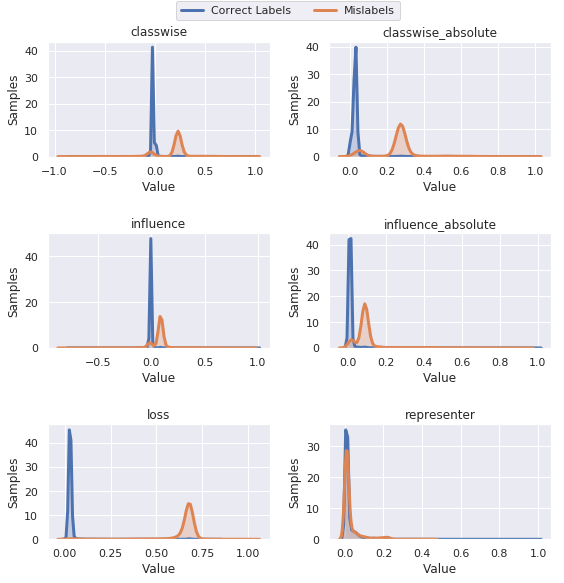

In [48]:
sorted_examples = sort_examples(mislabels, sorted_indices, sorted_scores)
create_distribution_plot(sorted_examples, expname, save=False)

In [61]:
def collect_corrsets(percs, sorted_indices, label_len):
    """Collects the correction sets for different inspection ratios

    Arguments:
        pers {array} -- inspection rates
        sorted_indices {array} -- ranking sorted indices
        label_len {int} -- dataset length

    Returns:
        dict -- correction lists for all percs
    """
    corr_list = {}
    for corr_perc in percs:
        corr_num = int(label_len * corr_perc // 100)
        corrset_dic = correction_sets(sorted_indices, corr_num)
        corr_key = str(corr_perc)
        corr_list[corr_key] = corrset_dic
    return corr_list

def create_comparison_plot(mislabels, corr_list, percs, expname, save):
    """Creates the comparison plot between the methods

    Arguments:
        mislabels {array} -- mislabeld indices
        corr_list {dict} -- different correction setups
        percs {array} -- inspection ratios
        expname {string} -- erperiment name 
        save {bool} -- flag to save the plot
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 4))
    ax.title.set_text('Comparison different inspection ratios')
    for mkey in corr_list[str(percs[0])].keys():
        values = []
        for pkey in percs:
            _, acc = get_corrections(mislabels, corr_list[str(pkey)][mkey])
            values.append(acc)
        ax.plot(percs, values, marker="o", label=mkey)
        
    ax.set_xlabel('Inspection ratio in %')
    ax.set_ylabel('Correction accuracy')
    
    handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(0.5,1.1), loc=9, ncol=5)
            
    plt.tight_layout(h_pad=2.0)
    path = '../plots/' + expname + '_comparison_inspection_ratios.png'
    if save:
        if not os.path.exists('../plots/'):
            os.makedirs('../plots/')
        fig.savefig(path, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.show()

Set 'percs' to determine the range of the inspection done for each experiment to see the improvement when inspecting more data.

In [68]:
percs = np.arange(0,15)

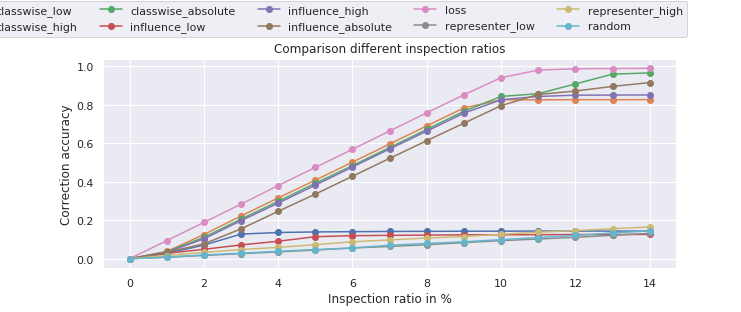

In [69]:
label_len = len(trainY)
corr_list = collect_corrsets(percs, sorted_indices, label_len)
create_comparison_plot(mislabels, corr_list, percs, expname, save=False)